#**BigRational**



## **Предисловие**

Исследрвание посвящено реализации длинной арифметике для рациональных чисел. Для этого предварительно реализована целочисленная длинная арифметика. Класс рациональных чисел хранит представление числа в виде обыкновенной несократимой дроби.

Тестирование не только охватывает основную функциональность, но и пристальное внимание уделяет тонким моментам реализации и сложным арифметическим операциям. Также добавлено сравнение времени работы умножения: в реализации класса, во встроенном умножении С++ и со встроенной длинной арифметикой в Python.

## **Описание**

Длинные числа хранятся в виде массива из int64_t, в каждой ячейке - число, меньшее BASE = INT64_MAX.
Длинные рациональные числа реализованы в виде двух длинных чисел - числителя и знаменателя.

## Функциональность

\\
### BigInt
* стандартные арифметические операции и операция взятия остатка от делаения
* операции инкремента и декремента, унарные плюс и минус
* операции сравнения
* операция взятия модуля (abs1)
* операция ввода/вывода, а также представление хранимого числа в виде строки
* каст к bool
* конструктор от числа, строки, копирования и присваивания.

\\
### BigRational
* те же, что и у BigInt
* каст к double с кастомной точностью
* приведение к десятичной дроби с кастомной точностью

## Умножение

Умножение выполняется рекурсивно методом Карацубы

Источники: https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%9A%D0%B0%D1%80%D0%B0%D1%86%D1%83%D0%B1%D1%8B

https://habr.com/ru/post/124258/
```
A0 = A[0 : A.size()/2]
B0 = B[0 : B.size()/2]

A1 = A[A.size()/2 : end_of_A]
B1 = B[B.size()/2 : end_of_B]

C0 = A0 * B0
C1 = A0 * B1
C2 = A1 * B0
*this = A1 * B1 + C0 + C1 + C2;
```

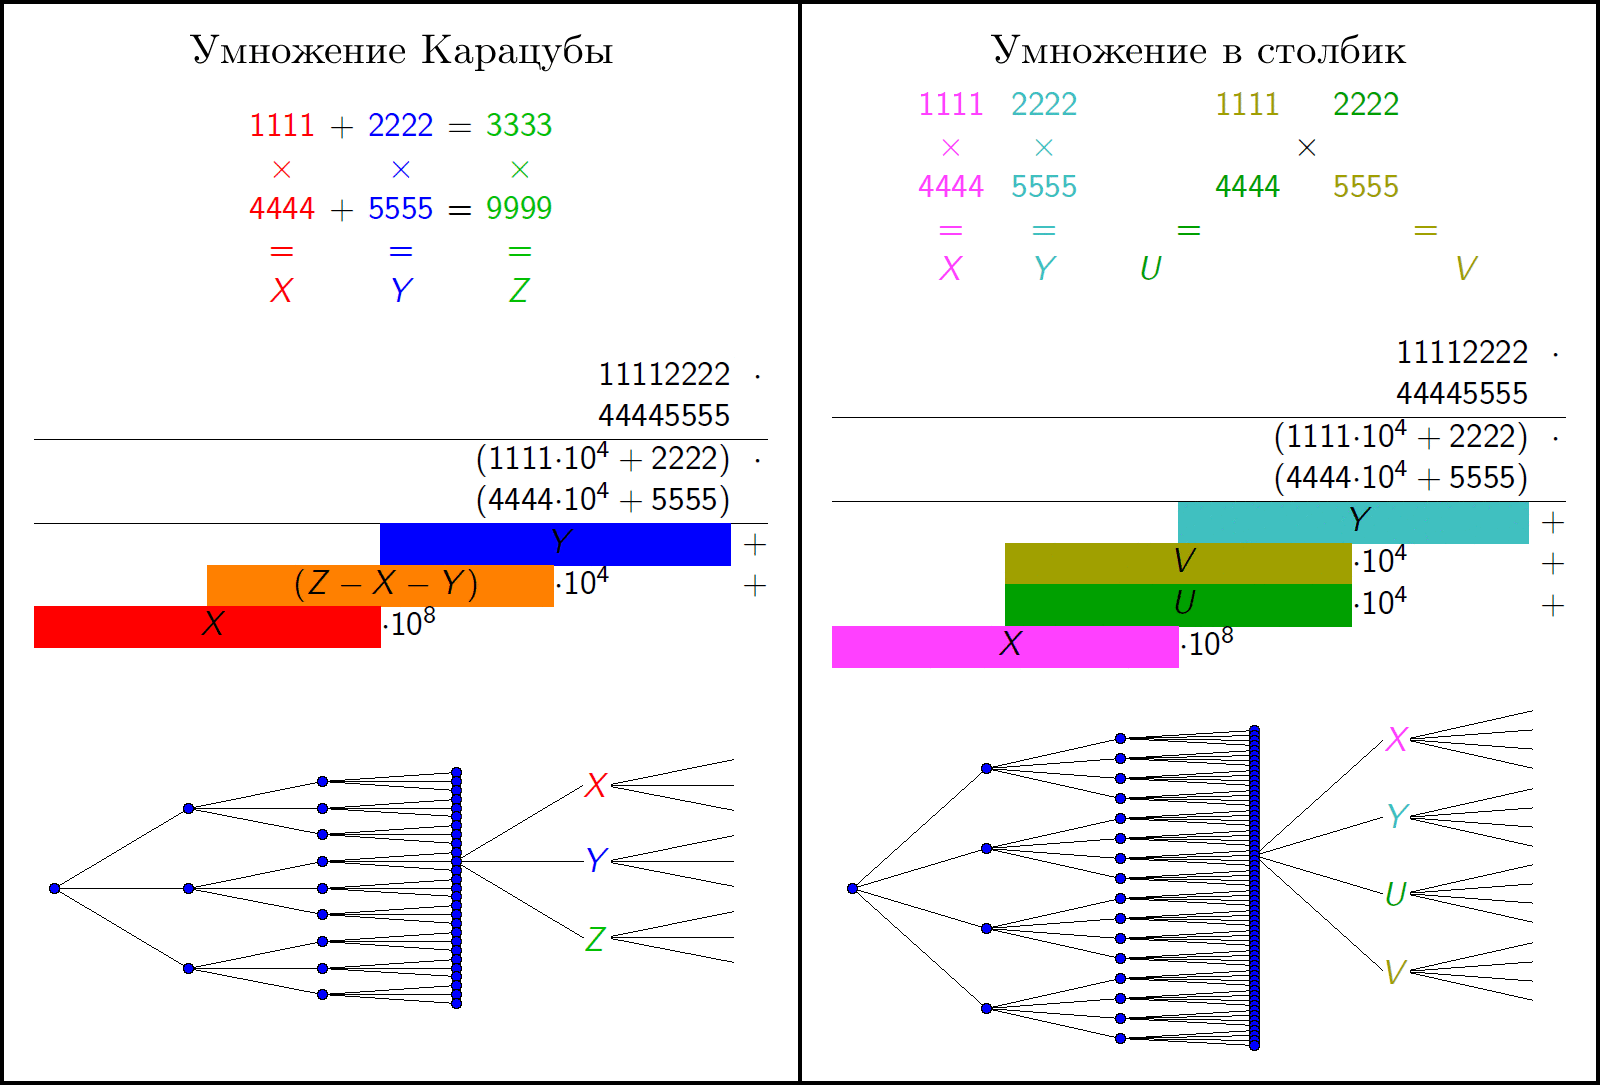

## **Тестирование**

### Тонкие моменты

**BigInt**

Проверим операции с различными знаками. Это важно, потому что сложение знаковых чисел надо прописывать четко (например, вычитание отрицательного или сложение отрицательных чисел). Проверяем только +=, тк все остальное сложение реализовано через него.

```
# Check += with different signs
        BigInteger A = 50, B = 3;
        int a = 50, b = 3;
        A += B;
        a += b;
        CHECK(A == a);
        A += -B;
        a -= b;
        CHECK(A == a);
        A = -A;
        A -= -B;
        a = -a;
        a -= -b;
        CHECK(A == a);
```

Аналогично для операций с нулем: +0 и -0 должны быть одинаковы во всем.
```
# Check operations with +-0
        BigInteger A = 50, B = 0;
        CHECK(A - A + B == B);
        CHECK(B * -1 == B);

```
\\
**Rational**

Проверим сокращение и проверку корректности хранимых чисел. Они максимально важны, тк используются в каждой операции.

```
# check & reduce
        CHECK_THROWS(Rational(1, 0));
        CHECK(Rational(0, 10) == Rational(-0));
        CHECK(Rational(1024, 512) == Rational(2));
        Rational A(18, 16), B(9, -8);
        CHECK(A + B == 0);
```

Наконец, проверим составные операции. Важно, чтобы реализация учитывала встроенную приоритетность операций в плюсах и при наличии коплексных арифметических выражений работала идентично.
```
# complex operations
        Rational A(1, 2), B(-2, 3);
        double a = 1.0/2, b = -2.0/3;
        A += ++B;
        a += ++b;
        CHECK(abs((double) A - a) < 0.001);
        A *= B++ * 2 + --A - A-- / 3 + A / B;
        a *= b++ * 2 + --a - a-- / 3 + a / b;
        CHECK(std::abs((double) A - a) < 0.001);
```

**Умножение**

В умножении есть два требующих внимания момента. \\
Первый -- правильная обработка умножения чисел с разным количеством занимаемых ячеек (одна или много).
Второй -- знаки.

У нас тестировалось сразу оба момента. Для более удобного сравнения со встроенным умножением, была выбрана *BASE = INT16_MAX*.



```
    SUBCASE("one on one") {
        BigInteger A(INT16_MAX / 2), B(INT16_MAX / 10), C(0);
        unsigned long long int a = INT16_MAX / 2, b = INT16_MAX / 10, c = 0;
        CHECK(A*B == a*b);
        CHECK((-A)*(B) == (-a)*(b));
        CHECK((-A)*(-B) == (-a)*(-b));
        CHECK((A)*(-B) == (a)*(-b));
    }
    SUBCASE("many on many") {
        BigInteger A(INT32_MAX / 1), B(INT32_MAX / 10), C(0);
        unsigned long long int a = INT32_MAX, b = INT32_MAX / 10, c = 0;
        C=A*B;
        c = a*b;
        CHECK(A*B == a*b);
        CHECK((-A)*(B) == (-a)*(b));
        CHECK((-A)*(-B) == (-a)*(-b));
        CHECK((A)*(-B) == (a)*(-b));
    }
    SUBCASE("many on one") {
        BigInteger A(INT32_MAX / 1), B(INT32_MAX / 100), C(0);
        unsigned long long int a = INT32_MAX, b = INT32_MAX / 100, c = 0;
        CHECK(A*B == a*b);
        CHECK((-A)*(B) == (-a)*(b));
        CHECK((-A)*(-B) == (-a)*(-b));
        CHECK((A)*(-B) == (a)*(-b));
    }
    SUBCASE("one on many") {
        BigInteger A(INT32_MAX / 100), B(INT32_MAX / 1), C(0);
        unsigned long long int a = INT32_MAX / 100, b = INT32_MAX / 1, c = 0;
        CHECK(A*B == a*b);
        CHECK((-A)*(B) == (-a)*(b));
        CHECK((-A)*(-B) == (-a)*(-b));
        CHECK((A)*(-B) == (a)*(-b));
    }
```



**Деление**

В делении все еще сложнее. К проблемам умножения добавляются еще две: деление с остатком и без. И само взятие остатка, конечно.

Аналогично умножению:


```
    SUBCASE("one on one") {
        BigInteger A(INT16_MAX / 2), B(INT16_MAX / 10), C(0);
        unsigned long long int a = INT16_MAX / 2, b = INT16_MAX / 10, c = 0;
        CHECK(A/B == a/b);
        CHECK((-A)/(B) == (-a)/(b));
        CHECK((-A)/(-B) == (-a)/(-b));
        CHECK((A)/(-B) == (a)/(-b));
    }
    SUBCASE("many on many") {
        BigInteger A(INT32_MAX / 1), B(INT32_MAX / 10), C(0);
        unsigned long long int a = INT32_MAX, b = INT32_MAX / 10, c = 0;
        CHECK(A/B == a/b);
        CHECK((-A)/(B) == (-a)/(b));
        CHECK((-A)/(-B) == (-a)/(-b));
        CHECK((A)/(-B) == (a)/(-b));
    }
    SUBCASE("many on one") {
        BigInteger A(INT32_MAX / 1), B(INT32_MAX / 100), C(0);
        unsigned long long int a = INT32_MAX, b = INT32_MAX / 100, c = 0;
        CHECK(A/B == a/b);
        CHECK((-A)/(B) == (-a)/(b));
        CHECK((-A)/(-B) == (-a)/(-b));
        CHECK((A)/(-B) == (a)/(-b));
    }
    SUBCASE("one on many") {
        BigInteger A(INT32_MAX / 100), B(INT32_MAX / 1), C(0);
        unsigned long long int a = INT32_MAX / 100, b = INT32_MAX / 1, c = 0;
        CHECK(A/B == a/b);
        CHECK((-A)/(B) == (-a)/(b));
        CHECK((-A)/(-B) == (-a)/(-b));
        CHECK((A)/(-B) == (a)/(-b));
    }
```

С остатком и без:


```
    SUBCASE("without remainder") {
        BigInteger A(2000000), B(1000000), C(0);
        unsigned long long int a = 2000000, b = 1000000, c = 0;
        CHECK(A/B == a/b);
        CHECK((-A)/(B) == (-a)/(b));
        CHECK((-A)/(-B) == (-a)/(-b));
        CHECK((A)/(-B) == (a)/(-b));
    }
    SUBCASE("with remainder") {
        BigInteger A(2000000), B(999999), C(0);
        unsigned long long int a = 2000000, b = 999999, c = 0;
        CHECK(A/B == a/b);
        CHECK((-A)/(B) == (-a)/(b));
        CHECK((-A)/(-B) == (-a)/(-b));
        CHECK((A)/(-B) == (a)/(-b));
    }
```

Взятие остатка:


```
    SUBCASE("%") {
        BigInteger A(2000000), B(999999), C(0);
        unsigned long long int a = 2000000, b = 999999, c = 0;
        CHECK(A%B == a%b);
        CHECK((-A)%(B) == (-a)%(b));
        CHECK((-A)%(-B) == (-a)%(-b));
        CHECK((A)%(-B) == (a)%(-b));
    }
```






## **Замеры времени на умножении**

### Прописанное умножение

Измерим время нашего умножения. Измеряется умножение *INT32_MAX* на *INT32_MAX / 10* при *BASE = INT16_MAX*

```
SUBCASE("my") {
        BigInteger A(INT32_MAX / 1), B(INT32_MAX / 10), C(0);
        auto start = std::chrono::steady_clock::now();
        int iter = 15;
        std::vector<double> times(iter);
        double med = 0, sq_med = 0;
        for (int i=0; i < iter; ++i) {
            auto s = std::chrono::steady_clock::now();
            C = A*B;
            auto e = std::chrono::steady_clock::now();
            times[i] = (s - e).count();
            med += (s - e).count();
            sq_med += (s - e).count() * (s - e).count();
        }
        double disp = (sq_med - med * med / iter) / iter;
        auto end = std::chrono::steady_clock::now();
        cout << "My multiply: " << (end - start).count() * 1.0 / iter << " Dispersion " << disp << endl;
    }
```

Время: 12954.8 нс \\
Дисперсия: 3.16968e+08 нс


### Встроенное умножение Python

В питоне также присутствует длинная арифметика, поэтому сравнимся и с ней на числах той же длины

In [1]:
import time

a = 123456789
b = 987654321

start = time.time_ns()
m, sm = 0, 0
for i in range(15):
  s = time.time_ns()
  c = a*b
  e = time.time_ns()
  m += e - s
  sm += (e - s) ** 2
disp = -(m*m / 15 - sm) / 15
end = time.time_ns()

print("Время: ", (end - start) / 15, " нс")
print("Дисперсия: ", disp, " нс")

Время:  8957.066666666668  нс
Дисперсия:  362.67822222222225  нс


### Встроенное умножение C++

Измерим встроенное умножение в плюсах. Точно также перемножим *INT32_MAX* на *INT32_MAX / 10*, эти числа хранятся в unsigned long long.

```
SUBCASE("built-in") {
        unsigned long long int A = INT32_MAX, B = INT32_MAX / 10, C = 0;
        auto start = std::chrono::steady_clock::now();
        int iter = 15;
        std::vector<double> times(iter);
        double med = 0, sq_med = 0;
        for (int i=0; i < iter; ++i) {
            auto s = std::chrono::steady_clock::now();
            C = A*B;
            auto e = std::chrono::steady_clock::now();
            times[i] = (s - e).count();
            med += (s - e).count();
            sq_med += (s - e).count() * (s - e).count();
        }
        double disp = (sq_med - med * med / iter) / iter;
        auto end = std::chrono::steady_clock::now();
        cout << "My multiply: " << (end - start).count() * 1.0 / iter << " Dispersion " << disp << endl;
    }
```

Время: 4.7333 нс \\
Дисперсия: 2.28997 нс

\\
### График и табличка

In [ ]:
times = [4.7333, (end - start) / 15, 12954.8]
names = ['c++', 'python', 'BigInt']

import matplotlib.pyplot as plt
plt.bar(names, times)
plt.ylabel('Time: ns')

In [2]:
import pandas as pd
tabledata = [["C++", 12954.8, 3.16968e+08],
         ["Python", (end - start) / 15, disp],
         ["BigInt", 4.73, 2.28]]
pd.DataFrame(tabledata, columns=["Источник","Среднее время", "Дисперсия"])

,Источник,Среднее время,Дисперсия
0,C++,12954.800000,3.169680e+08
1,Python,8957.066667,3.626782e+02
2,BigInt,4.730000,2.280000e+00


## **Исходники**

BigInteger, Rational, тесты и CmakeLists: https://github.com/und3f1n3d5/BigRational_SE

 Длинные числа хранятся в виде массива из *int64_t*, в каждой ячейке - число, меньшее *BASE = INT64_MAX*